In [1]:
# Environment variable
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
# === Standard Libraries ===
import gc
import os
import re
import time
import itertools
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

# === Third-Party Libraries ===
import equinox as eqx
import h5py
import jax
import jax.numpy as jnp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import optax
import seaborn as sns
from jax import config, lax, random, vmap
from jax.flatten_util import ravel_pytree
from jax.scipy.optimize import minimize
from scipy.interpolate import griddata
from scipy.stats import gmean
from tqdm import tqdm

# === Local Project Modules ===
from pinn_toolkit.derivative import Derivative
from pinn_toolkit.sampler import Sampler
from pinn_toolkit.train import Train
from pinn_toolkit.util import (
    L2, tree_to_f32, get_i, get_len, hex_to_key, key_to_hex,
    load_model, save_model, load_pytree, save_pytree,
    map_span, map_span_dict, split_pytree, stratified_subset,
)
from pinn_toolkit.validation import (
    find_model_paths, compute_errs,
    evaluate_model_performance, avg_err_metric_dotplot,
    plot_loss_history, aggregated_loss_history
)

# == import local modules ===
from model import PINN
from pde_dimless import PDE_dimless
from residual import Residual

# === Script Initialization ===
key = random.PRNGKey(41734346)

In [3]:
config.update("jax_enable_x64", True)
pdeparams_phys = {
    "alpha_phi": 9.62e-5, "omega_phi": 1.663e7, "M": 8.5e-10 / (2 * 5.35e7),
    "A": 5.35e7, "L": 1e-11, "c_se": 1.0, "c_le": 5100/1.43e5, "x_range": (-50.0e-6, 50.0e-6),
    "t_range": (0, 1.0e5), "nx": 128, "nt": 128, "l_0": 2*50.0e-6, "t_0": 1.0e5
}

pdedimless = PDE_dimless(pdeparams_phys)

span_pde = {
    'x':pdedimless.x_range_nd,'t':pdedimless.t_range_nd,'L':(1e-12, 1e-10),'M':(1e-21, 1e-19)
}
span_model = {'x':(-0.5,0.5), 't':(0,1),'L':(0,1),'M':(0,1)}

In [4]:
# task, write a function that does this:
jax.config.update("jax_enable_x64", False)
os.environ['JAX_PLATFORMS'] = 'cuda'
print(f"JAX has been configured to use {jax.devices()}.")

# construct model
from model import PINN
jax.config.update("jax_enable_x64", False)
inp_idx = {'x':0, 't':1, 'L':2, 'M':3}
out_idx = {'phi':0, 'c':1}
width = 32
depth = 4
base_model = PINN(inp_idx, out_idx, span_pde, span_model, width, depth)

JAX has been configured to use [CudaDevice(id=0)].


In [5]:
filename = os.path.join('data','2rqmc_5k_128*128')
models_dir = "models"
names = ['test_run']
methods = ['grid', 'sobol', 'gridInner', 'uniformRandom']
sizes = [7,10]
paths = find_model_paths(models_dir, names, methods, sizes)

In [6]:
summary = evaluate_model_performance(filename, base_model, names, methods, sizes, models_dir, eval_chunk_size=20)

Starting evaluation on: data/2rqmc_5k_128*128
Found 32 models to evaluate.
Progress: 32/32 | Evaluating: test_run_uniformRandom_7_dbe9f6710322c93c_9b16657b5654d462....
Finished evaluation.
Evaluated 32 models in 3.91s (0.122s/model).


Saved plot to plots/test_run_all_L1_dotplot.png
Saved plot to plots/test_run_all_L2_dotplot.png


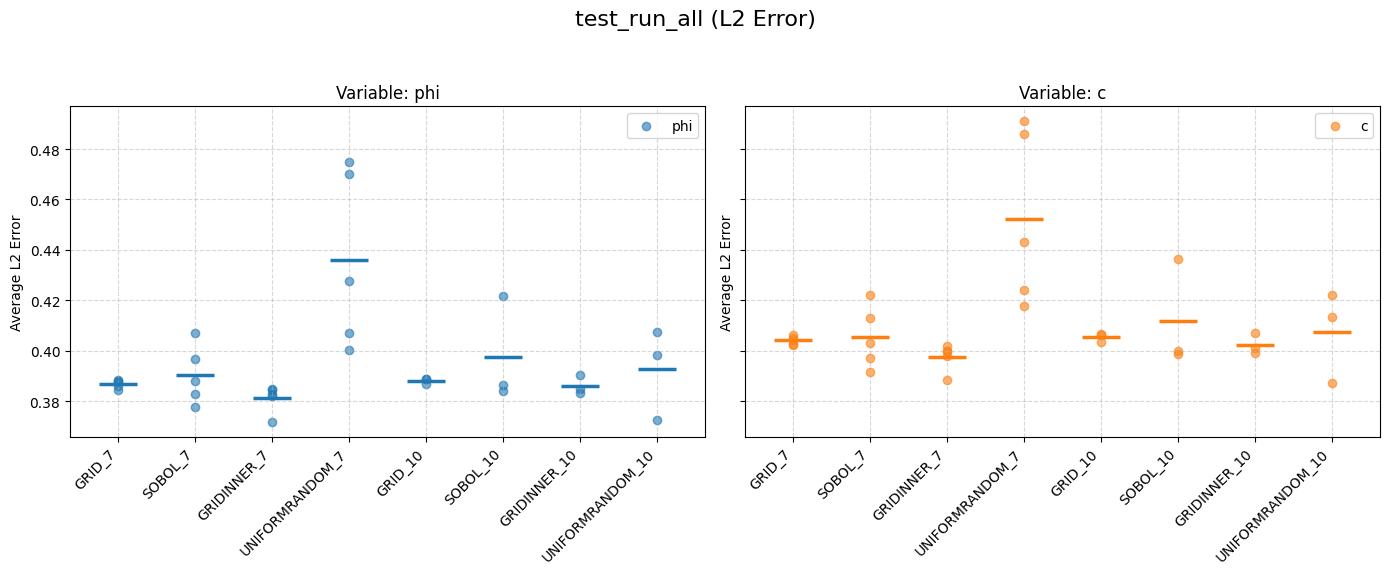

Saved plot to plots/test_run_all_Linf_dotplot.png


In [7]:
plot_name = "test_run_all"
use_log_scale = False
out_dir = os.path.join("plots")
names = ['test_run']
methods = ['grid', 'sobol', 'gridInner', 'uniformRandom']
sizes = [7,10]
avg_err_metric_dotplot(summary, names, methods, sizes, plot_name, use_log_scale, out_dir)

Starting aggregated loss history plotting...
Found 20 models across 4 families.
[PLOT] Plotting LINE for 'test_run_sobol_7 (Geom)' with 1201 points.
[PLOT] Plotting SCATTER for 'test_run_sobol_7 (L2_phi)' with 61 points.
[PLOT] Plotting SCATTER for 'test_run_sobol_7 (L2_c)' with 61 points.
[PLOT] Plotting LINE for 'test_run_gridInner_7 (Geom)' with 1201 points.
[PLOT] Plotting SCATTER for 'test_run_gridInner_7 (L2_phi)' with 61 points.
[PLOT] Plotting SCATTER for 'test_run_gridInner_7 (L2_c)' with 61 points.
[PLOT] Plotting LINE for 'test_run_grid_7 (Geom)' with 1201 points.


/home/fangkoukou/pinn/JAX-PF-PINN-4.0/src/pinn_toolkit/validation.py:674: RuntimeWarning: Mean of empty slice
  avg_loss = np.nanmean(np.asarray(padded), axis=0)


[PLOT] Plotting SCATTER for 'test_run_grid_7 (L2_phi)' with 61 points.
[PLOT] Plotting SCATTER for 'test_run_grid_7 (L2_c)' with 61 points.
[PLOT] Plotting LINE for 'test_run_uniformRandom_7 (Geom)' with 1201 points.
[PLOT] Plotting SCATTER for 'test_run_uniformRandom_7 (L2_phi)' with 61 points.
[PLOT] Plotting SCATTER for 'test_run_uniformRandom_7 (L2_c)' with 61 points.
------------------------------------------------------------ 
Saved aggregated plot to: plots/aggregated_loss.png


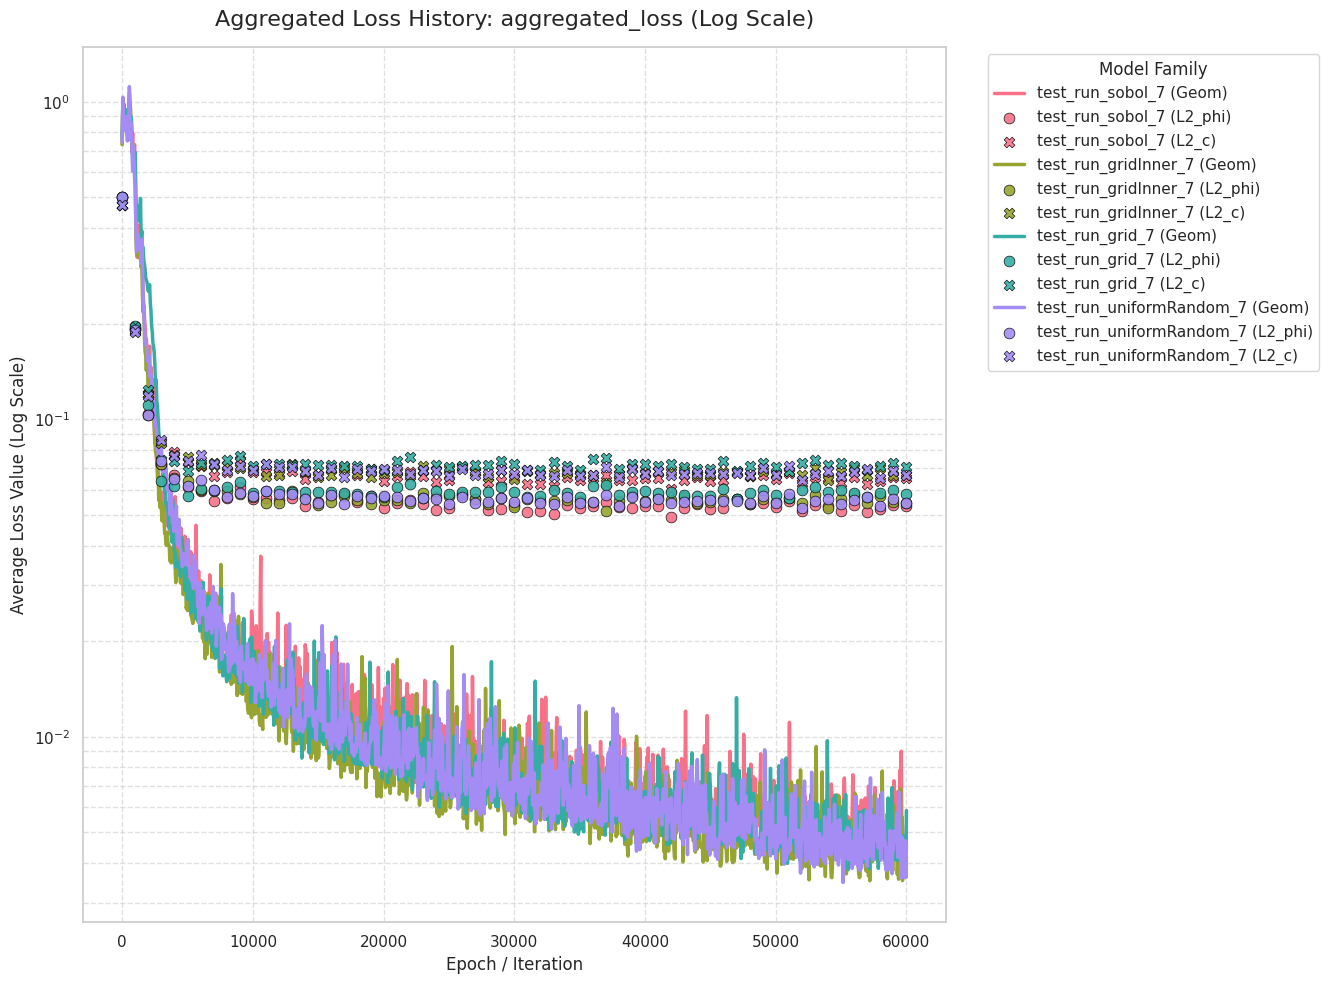

In [8]:
names = ['test_run']
methods = ['grid', 'sobol', 'gridInner', 'uniformRandom']
sizes = [7]
aggregated_loss_history(names, methods, sizes, models_dir, "aggregated_loss", out_dir = out_dir, skip1 = 50, skip2 = 10, log_scale=True)

In [9]:
# plot_loss_history(names, methods, sizes, models_dir = "models_rqmc4", skip1 = 50, skip2 = 10, log_scale=True)